# Import necessary libraries

In [1]:
!pip install fbprophet

In [11]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# Read in the data

Read the data in from the retail sales CSV file in the examples folder then set the index to the 'date' column. We are also parsing dates in the data file.

In [3]:
sales_df = pd.read_csv('retail_sales.csv', index_col='date', parse_dates=True)

In [4]:
sales_df.head(100)

,sales
date,
2009-10-01,338630
2009-11-01,339386
2009-12-01,400264
2010-01-01,314640
2010-02-01,311022
2010-03-01,360819
2010-04-01,356460
2010-05-01,365713
2010-06-01,358675


# Prepare for Prophet

For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy (you'll see why later). The new dataframe will initially be created with an integer index so we can rename the columns

In [5]:
df = sales_df.reset_index()

In [7]:
df.head(20)

,date,sales
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022
5,2010-03-01,360819
6,2010-04-01,356460
7,2010-05-01,365713
8,2010-06-01,358675
9,2010-07-01,362027


Let's rename the columns as required by fbprophet. Additioinally, fbprophet doesn't like the index to be a datetime...it wants to see 'ds' as a non-index column, so we won't set an index differnetly than the integer index.

In [8]:
df=df.rename(columns={'date':'ds', 'sales':'y'})

In [9]:
df.head(20)

,ds,y
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022
5,2010-03-01,360819
6,2010-04-01,356460
7,2010-05-01,365713
8,2010-06-01,358675
9,2010-07-01,362027


Now's a good time to take a look at your data.  Plot the data using pandas' ```plot``` function

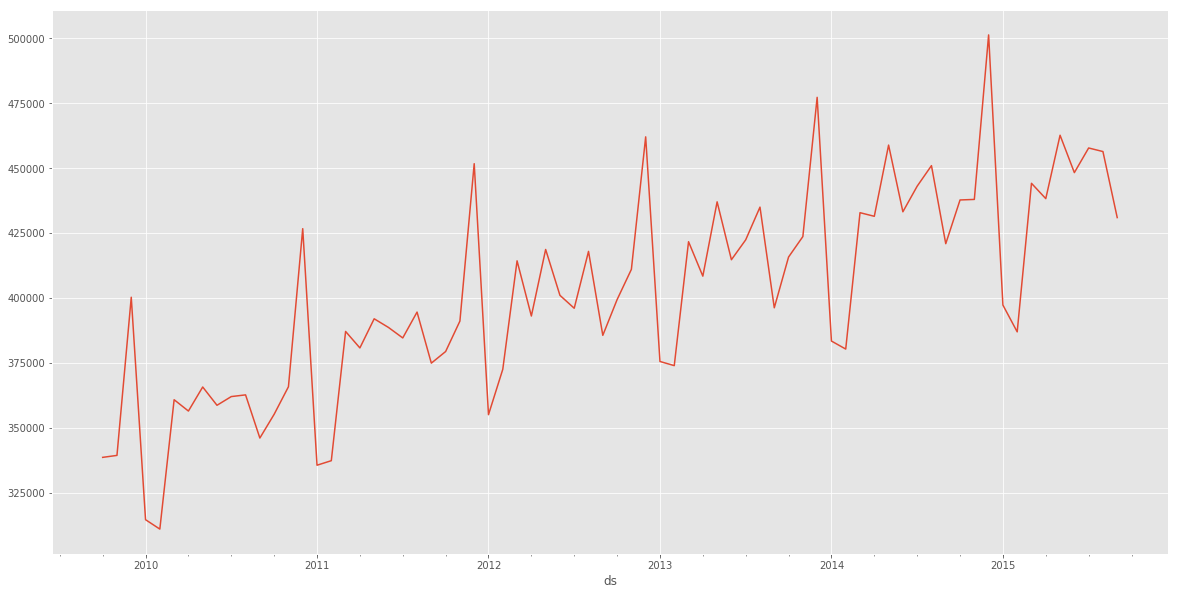

In [12]:
df.set_index('ds').y.plot()

When working with time-series data, its good to take a look at the data to determine if trends exist, whether it is stationary, has any outliers and/or any other anamolies. Facebook prophet's example uses the log-transform as a way to remove some of these anomolies but it isn't the absolute 'best' way to do this...but given that its the example and a simple data series, I'll follow their lead for now.  Taking the log of a number is easily reversible to be able to see your original data. 

To log-transform your data, you can use numpy's log() function

In [13]:
df['y'] = np.log(df['y'])

In [14]:
df.tail()

,ds,y
67,2015-05-01,13.044650
68,2015-06-01,13.013060
69,2015-07-01,13.033991
70,2015-08-01,13.030993
71,2015-09-01,12.973671


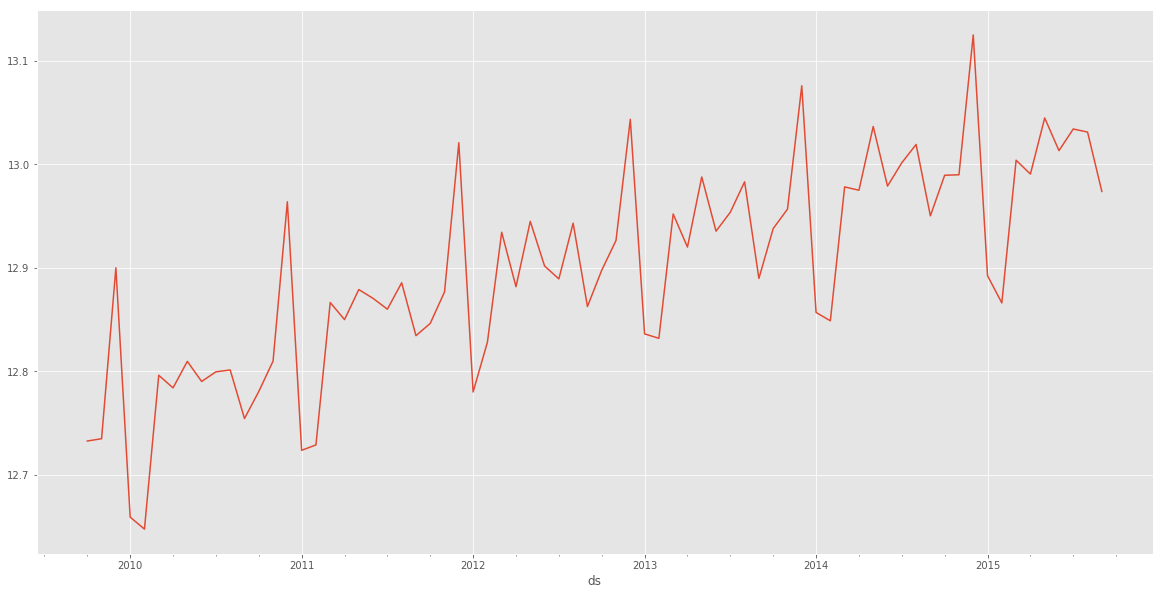

In [15]:
df.set_index('ds').y.plot()

As you can see in the above chart, the plot looks the same as the first one but just at a different scale.

# Running Prophet

Now, let's set prophet up to begin modeling our data.

Note: Since we are using monthly data, you'll see a message from Prophet saying ```Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.```  This is OK since we are workign with monthly data but you can disable it by using ```weekly_seasonality=True``` in the instantiation of Prophet.

In [16]:
model = Prophet()
model.fit(df);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting is fairly useless unless you can look into the future, so we need to add some future dates to our dataframe. For this example, I want to forecast 2 years into the future, so I'll built a future dataframe with 24 periods since we are working with monthly data. Note the ```freq='m'``` inclusion to ensure we are adding 24 months of data.

This can be done with the following code:


In [17]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

,ds
91,2017-04-30
92,2017-05-31
93,2017-06-30
94,2017-07-31
95,2017-08-31


To forecast this future data, we need to run it through Prophet's model.

In [18]:
forecast = model.predict(future)

The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns.  First, let's look at the full dataframe:

In [19]:
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
91,2017-04-30,13.041977,12.905393,13.200219,12.926532,13.220699,0.020388,0.020388,0.020388,0.0,0.0,0.0,0.020388,0.020388,0.020388,13.062366
92,2017-05-31,13.043661,12.895950,13.209619,12.908069,13.226047,0.012533,0.012533,0.012533,0.0,0.0,0.0,0.012533,0.012533,0.012533,13.056194
93,2017-06-30,13.045291,12.885716,13.223169,12.918377,13.260042,0.029787,0.029787,0.029787,0.0,0.0,0.0,0.029787,0.029787,0.029787,13.075078
94,2017-07-31,13.046974,12.875615,13.241087,12.882752,13.251391,0.006610,0.006610,0.006610,0.0,0.0,0.0,0.006610,0.006610,0.006610,13.053584
95,2017-08-31,13.048658,12.868122,13.253787,12.840924,13.230999,-0.023275,-0.023275,-0.023275,0.0,0.0,0.0,-0.023275,-0.023275,-0.023275,13.025383


We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:

In [20]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
91,2017-04-30,13.062366,12.926532,13.220699
92,2017-05-31,13.056194,12.908069,13.226047
93,2017-06-30,13.075078,12.918377,13.260042
94,2017-07-31,13.053584,12.882752,13.251391
95,2017-08-31,13.025383,12.840924,13.230999


# Plotting Prophet results

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

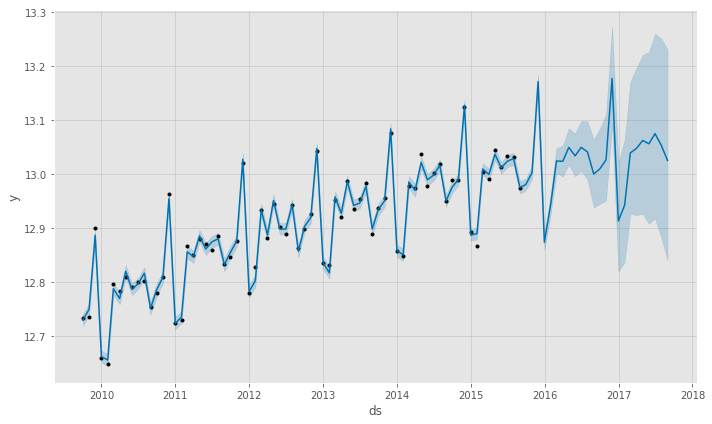

In [21]:
model.plot(forecast);

Personally, I'm not a fan of this visualization so I like to break the data up and build a chart myself.  The next section describes how I build my own visualization for Prophet modeling 

# Visualizing Prophet models

In order to build a useful dataframe to visualize our model versus our original data, we need to combine the output of the Prophet model with our original data set, then we'll build a new chart manually using pandas and matplotlib.

First, let's set our dataframes to have the same index of ```ds```

In [22]:
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

Now, we'll combine the original data and our forecast model data

In [23]:
viz_df = sales_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

If we look at the ```head()```, we see the data has been joined correctly but the scales of our original data (sales) and our model (yhat) are different. We need to rescale the yhat colums(s) to get the same scale, so we'll use numpy's ```exp``` function to do that.

In [25]:
viz_df.head(100)

,sales,yhat,yhat_lower,yhat_upper
2009-10-01,338630.0,12.729761,12.719058,12.740822
2009-11-01,339386.0,12.749481,12.738304,12.759656
2009-12-01,400264.0,12.886795,12.875587,12.896974
2010-01-01,314640.0,12.661953,12.650955,12.672988
2010-02-01,311022.0,12.655577,12.644810,12.665869
2010-03-01,360819.0,12.787781,12.776168,12.798658
2010-04-01,356460.0,12.769644,12.758791,12.780145
2010-05-01,365713.0,12.820092,12.808925,12.831330
2010-06-01,358675.0,12.786793,12.775779,12.797779
2010-07-01,362027.0,12.796661,12.786974,12.807137


In [26]:
viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])

In [27]:
viz_df.head(100)

,sales,yhat,yhat_lower,yhat_upper,yhat_rescaled
2009-10-01,338630.0,12.729761,12.719058,12.740822,337648.762478
2009-11-01,339386.0,12.749481,12.738304,12.759656,344373.017467
2009-12-01,400264.0,12.886795,12.875587,12.896974,395060.755646
2010-01-01,314640.0,12.661953,12.650955,12.672988,315512.413385
2010-02-01,311022.0,12.655577,12.644810,12.665869,313506.881518
2010-03-01,360819.0,12.787781,12.776168,12.798658,357818.524294
2010-04-01,356460.0,12.769644,12.758791,12.780145,351387.253154
2010-05-01,365713.0,12.820092,12.808925,12.831330,369568.640174
2010-06-01,358675.0,12.786793,12.775779,12.797779,357465.223770
2010-07-01,362027.0,12.796661,12.786974,12.807137,361009.866818


Let's take a look at the ```sales``` and ```yhat_rescaled``` data together in a chart.

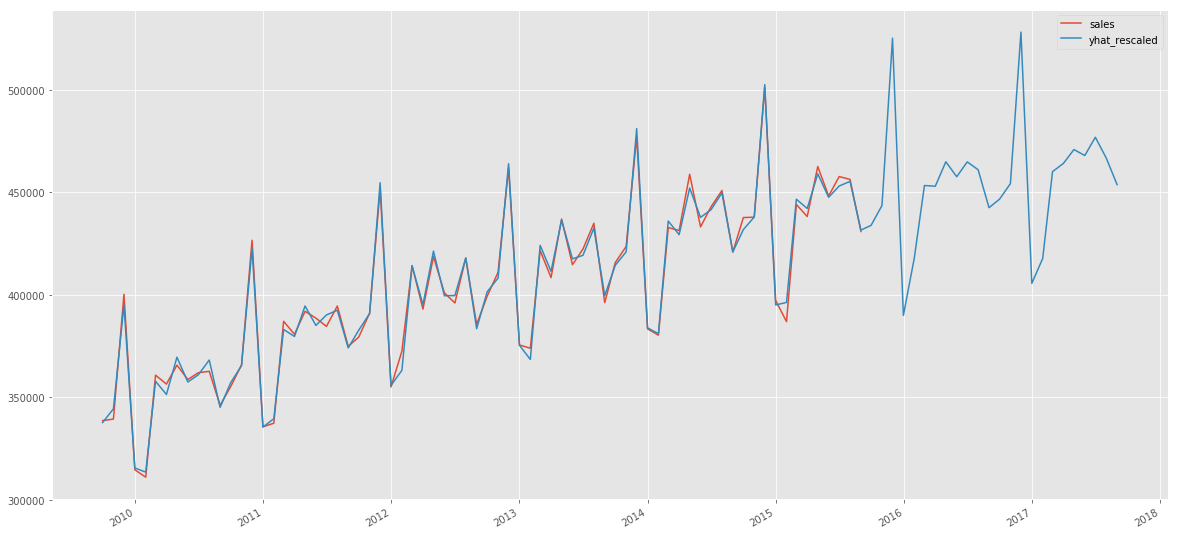

In [28]:
viz_df[['sales', 'yhat_rescaled']].plot()

You can see from the chart that the model (blue) is pretty good when plotted against the actual signal (orange) but I like to make my vizualization's a little better to understand.   To build my 'better' visualization, we'll need to go back to our original ```sales_df``` and ```forecast``` dataframes.

First things first - we need to find the 2nd to last date of the original sales data in ```sales_df``` in order to ensure the original sales data and model data charts are connected. 

In [29]:
sales_df.index = pd.to_datetime(sales_df.index) #make sure our index as a datetime object
connect_date = sales_df.index[-2] #select the 2nd to last date

Using the ```connect_date``` we can now grab only the model data that after that date (you'll see why in a minute). To do this, we'll mask the forecast data.

In [30]:
mask = (forecast.index > connect_date)
predict_df = forecast.loc[mask]

In [31]:
predict_df.head(100)

,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
ds,,,,,,,,,,,,,,,
2015-09-01,13.009006,13.009006,13.009006,12.963987,12.987071,-0.033755,-0.033755,-0.033755,0.0,0.0,0.0,-0.033755,-0.033755,-0.033755,12.975251
2015-09-30,13.010582,13.010313,13.010859,12.969768,12.991612,-0.030007,-0.030007,-0.030007,0.0,0.0,0.0,-0.030007,-0.030007,-0.030007,12.980575
2015-10-31,13.012265,13.009859,13.014910,12.991262,13.014530,-0.009637,-0.009637,-0.009637,0.0,0.0,0.0,-0.009637,-0.009637,-0.009637,13.002629
2015-11-30,13.013895,13.008748,13.019653,13.158839,13.185143,0.157656,0.157656,0.157656,0.0,0.0,0.0,0.157656,0.157656,0.157656,13.171551
2015-12-31,13.015579,13.006199,13.025923,12.859368,12.888067,-0.141770,-0.141770,-0.141770,0.0,0.0,0.0,-0.141770,-0.141770,-0.141770,12.873809
2016-01-31,13.017263,13.003076,13.032559,12.925724,12.961675,-0.074404,-0.074404,-0.074404,0.0,0.0,0.0,-0.074404,-0.074404,-0.074404,12.942859
2016-02-29,13.018838,13.000284,13.039517,13.002290,13.048038,0.005574,0.005574,0.005574,0.0,0.0,0.0,0.005574,0.005574,0.005574,13.024412
2016-03-31,13.020522,12.996506,13.048241,12.995522,13.052665,0.003144,0.003144,0.003144,0.0,0.0,0.0,0.003144,0.003144,0.003144,13.023666
2016-04-30,13.022151,12.991459,13.055864,13.017624,13.084896,0.027491,0.027491,0.027491,0.0,0.0,0.0,0.027491,0.027491,0.027491,13.049643


Now, let's build a dataframe to use in our new visualization. We'll follow the same steps we did before.

In [32]:
viz_df = sales_df.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df['yhat_scaled']=np.exp(viz_df['yhat'])

Now, if we take a look at the ```head()``` of ```viz_df``` we'll see 'NaN's everywhere except for our original data rows.  

In [33]:
viz_df.head(10)

,sales,yhat,yhat_lower,yhat_upper,yhat_scaled
2009-10-01,338630.0,NaN,NaN,NaN,NaN
2009-11-01,339386.0,NaN,NaN,NaN,NaN
2009-12-01,400264.0,NaN,NaN,NaN,NaN
2010-01-01,314640.0,NaN,NaN,NaN,NaN
2010-02-01,311022.0,NaN,NaN,NaN,NaN
2010-03-01,360819.0,NaN,NaN,NaN,NaN
2010-04-01,356460.0,NaN,NaN,NaN,NaN
2010-05-01,365713.0,NaN,NaN,NaN,NaN
2010-06-01,358675.0,NaN,NaN,NaN,NaN
2010-07-01,362027.0,NaN,NaN,NaN,NaN


If we take a look at the ```tail()``` of the ```viz_df``` you'll see we have data for the forecasted data and NaN's for the original data series.

In [34]:
viz_df.tail()

,sales,yhat,yhat_lower,yhat_upper,yhat_scaled
2017-04-30,NaN,13.062366,12.926532,13.220699,470883.297622
2017-05-31,NaN,13.056194,12.908069,13.226047,467986.223264
2017-06-30,NaN,13.075078,12.918377,13.260042,476907.492767
2017-07-31,NaN,13.053584,12.882752,13.251391,466766.413473
2017-08-31,NaN,13.025383,12.840924,13.230999,453786.911047


## time to plot

Now, let's plot everything to get the 'final' visualization of our sales data and forecast with errors.

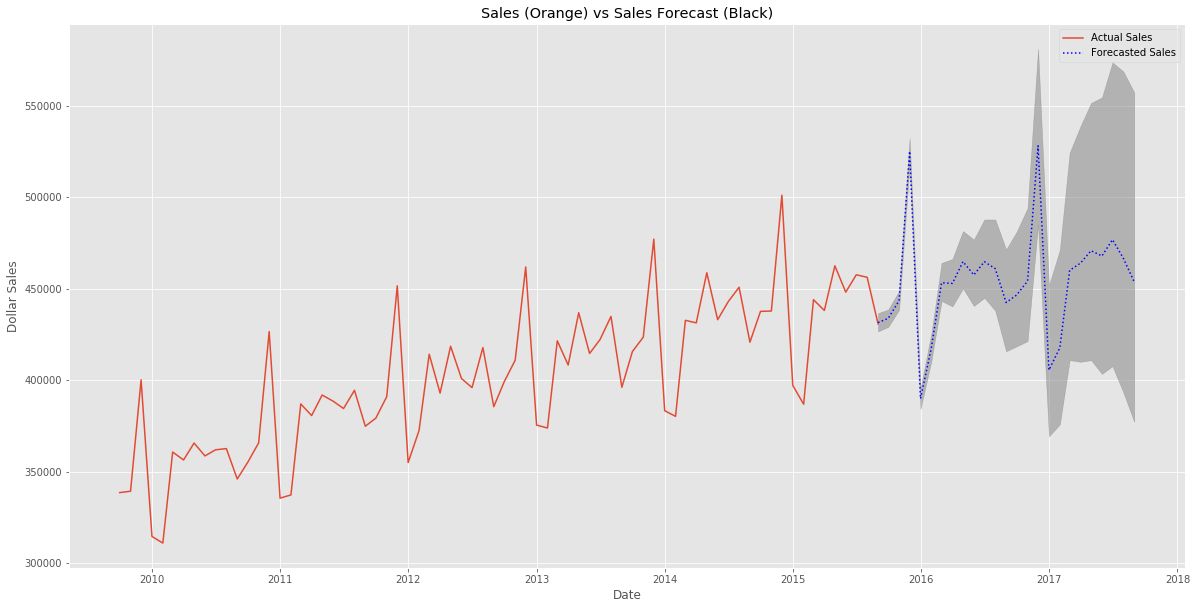

In [38]:
fig, ax1 = plt.subplots()
ax1.plot(viz_df.sales)
ax1.plot(viz_df.yhat_scaled, color='blue', linestyle=':')
ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='grey')
ax1.set_title('Sales (Orange) vs Sales Forecast (Black)')
ax1.set_ylabel('Dollar Sales')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('Actual Sales') #change the legend text for 1st plot
L.get_texts()[1].set_text('Forecasted Sales') #change the legend text for 2nd plot